# Graph Neural Network

## Import Required Libraries

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt


## Load Dataset

In [3]:
# Load the Cora citation dataset
dataset = Planetoid(root = "./data", name = "Cora")

# Access the graph
data = dataset[0]

Processing...
Done!


## GNN Model Definition

In [4]:
# Define the GNN model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim = 1)


## Model Training

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN(input_dim = dataset.num_node_features,
            hidden_dim = 16,
            output_dim = dataset.num_classes).to(device)

data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = 5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 1.9552
Epoch 20, Loss: 0.1260
Epoch 40, Loss: 0.0157
Epoch 60, Loss: 0.0152
Epoch 80, Loss: 0.0176
Epoch 100, Loss: 0.0163
Epoch 120, Loss: 0.0144
Epoch 140, Loss: 0.0131
Epoch 160, Loss: 0.0121
Epoch 180, Loss: 0.0113


## Evaluate

In [6]:
model.eval()
with torch.no_grad():
    pred = model(data).argmax(dim = 1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.8110


## Visualize Results

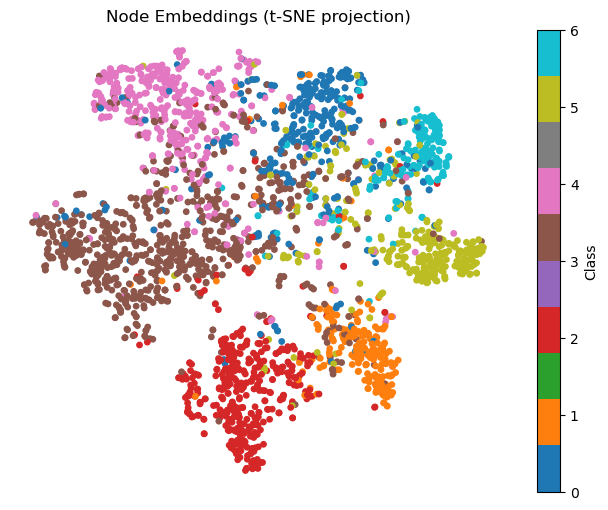

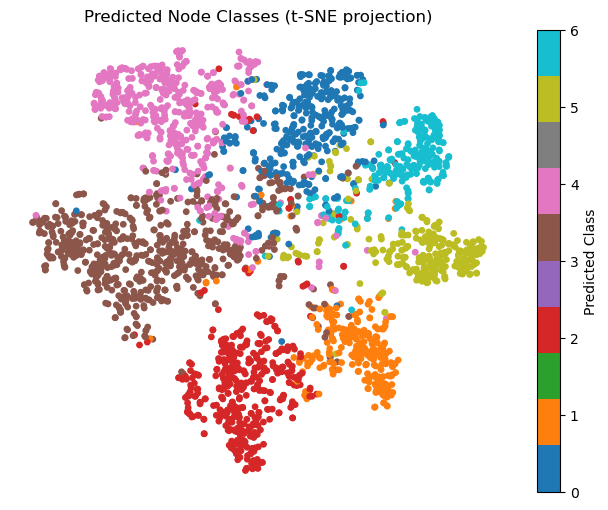

In [8]:
def get_embeddings(model, data):
    model.eval()
    with torch.no_grad():
        x, edge_index = data.x, data.edge_index
        x = model.conv1(x, edge_index)
        x = F.relu(x)
    return x.cpu()


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Get hidden embeddings (after first GCN layer)
embeddings = get_embeddings(model, data)

# Use t-SNE for dimensionality reduction
tsne = TSNE(n_components = 2, random_state = 42)
embeddings_2d = tsne.fit_transform(embeddings)

# Get true labels
labels = data.y.cpu()


plt.figure(figsize = (8, 6))
scatter = plt.scatter(embeddings_2d[:, 0],
                      embeddings_2d[:, 1],
                      c = labels,
                      cmap = "tab10",
                      s = 15)
plt.colorbar(scatter, label = "Class")
plt.title("Node Embeddings (t-SNE projection)")
plt.axis("off")
plt.show()


pred_labels = pred.cpu()

plt.figure(figsize = (8, 6))
scatter = plt.scatter(embeddings_2d[:, 0],
                      embeddings_2d[:, 1],
                      c = pred_labels,
                      cmap = "tab10",
                      s = 15)
plt.colorbar(scatter, label = "Predicted Class")
plt.title("Predicted Node Classes (t-SNE projection)")
plt.axis("off")
plt.show()